# Table of Contents <a id='top'></a> 
                                                          

1. [Import Packages](#imports)<br>
2. [Define Functions](#functions)<br> 
3. [Conduct Experiments](#experiments)<br> 
4. [Visualize Results](#visualize)<br> 

---
## 1: Import Packages <a id='imports'></a> 
[jump to top](#top)<br>

In [1]:
# modules I created
from bidder import Bidder
from auction import Auction, User

# outside libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

--- 
## 2: Define Functions <a id='functions'></a> 
[jump to top](#top)<br>

In [2]:
def run_experiment(auction):
    for i in range(auction.bidders[0].num_rounds):
        auction.execute_round()

In [3]:
def overview(auction, game_state_id = None):
    """Given a completed auction (an auction object for which .execute() has been repeatedly called),
    summarize the attributes of the bidders involved and indicate the final balance of each bidder"""
    
    dicty = {"auction_id": [],
             "bidder_id": [],
             "bidder_type": [],
             "alpha": [],
             "aggressiveness": [],
             "under_cut": [],
             "num_users": [],
             "final_balance": []}

    for bidder in auction.bidders:
        dicty["auction_id"].append(auction.auction_id)
        dicty["bidder_id"].append(bidder.bidder_id)
        dicty["bidder_type"].append(bidder.bidder_type)
        if bidder.bidder_type == "smart":
            dicty["alpha"].append(bidder.alpha)
            dicty["aggressiveness"].append(bidder.aggressiveness)
            dicty["under_cut"].append(bidder.under_cut)
        else:
            dicty["alpha"].append("NA")
            dicty["aggressiveness"].append("NA")
            dicty["under_cut"].append("NA")
        dicty["num_users"].append(len(auction.users))
        dicty["final_balance"].append(auction.balances[bidder])

    summary_df = pd.DataFrame(dicty)
    
    if game_state_id != None:
        summary_df["game_state_id"] = [game_state_id for i in range(len(summary_df))]
        return summary_df[["auction_id"] + ["game_state_id"] + ["bidder_id", "bidder_type", "alpha", "aggressiveness", "under_cut", "num_users", "final_balance"]]
    else:
        return summary_df


--- 
## 3: Conduct Experiments <a id='experiments'></a> 
[jump to top](#top)<br>

In [4]:
alpha_levels = [i/10 for i in range(10)]
aggressiveness_levels = [i/20 for i in range(20)]
under_cut_levels = [i/20 for i in range(0, 5)]

In [5]:
dict_bidders = {"bidder_id":[], "alpha": [], "aggressiveness": [], "under_cut": []}

i = 0
for alpha in alpha_levels:
    for agg in aggressiveness_levels:
        for undercut in under_cut_levels:
            dict_bidders["bidder_id"].append(i)
            dict_bidders["alpha"].append(alpha)
            dict_bidders["aggressiveness"].append(agg)
            dict_bidders["under_cut"].append(undercut)
            i += 1
            
df_bidders = pd.DataFrame(dict_bidders)  
df_bidders["num_auctions_played"] = [0 for i in range(len(df_bidders))]
df_bidders["total_balance"] = [0 for i in range(len(df_bidders))]
# df_bidders["average_final_balance"] = df_bidders["total_balance"] / df_bidders["num_auctions_played"]
df_bidders['average_final_balance'] = df_bidders.apply(
    lambda row: row['total_balance'] / row['num_auctions_played'] if row['num_auctions_played'] != 0 else 0,
    axis=1
)
df_bidders

,bidder_id,alpha,aggressiveness,under_cut,num_auctions_played,total_balance,average_final_balance
0,0,0.0,0.00,0.00,0,0,0
1,1,0.0,0.00,0.05,0,0,0
2,2,0.0,0.00,0.10,0,0,0
3,3,0.0,0.00,0.15,0,0,0
4,4,0.0,0.00,0.20,0,0,0
...,...,...,...,...,...,...,...
995,995,0.9,0.95,0.00,0,0,0
996,996,0.9,0.95,0.05,0,0,0
997,997,0.9,0.95,0.10,0,0,0
998,998,0.9,0.95,0.15,0,0,0


My idea right now is to randomly draw a random number of bidders from that data frame ^ and run an auction with them. Then I will repeat this over and over again until each bidder has been selected like 10 times (?). 

In [6]:
def run_record_auction():
    """Calling this function modifies the df_bidders dataframe created above by populating it with the
    performance of the involved bidders after a single auction definition has executed 1000 rounds"""
    
    # instantiate 10 users
    users = [User() for i in range(10)]
    
    # decide how many smart bidders will participate, it will be anywhere from 5 to 9
    num_bidders = np.random.randint(5, 10)

    # randomly select bidders from the table df_bidders 
    bidders_ids = np.random.choice(df_bidders.index, num_bidders)
    
    # instantiate the bidders with the attributes defined in the df_bidders table
    bidders = [Bidder(num_users=10, num_rounds=1000, bidder_type="zero")] + [Bidder(10, 1000, bidder_id = bidders_ids[i], bidder_type="smart", alpha=df_bidders.loc[bidders_ids[i]][1], aggressiveness=df_bidders.loc[bidders_ids[i]][2], under_cut=df_bidders.loc[bidders_ids[i]][3]) for i in range(num_bidders)] + [Bidder(num_users=10, num_rounds=1000, bidder_type="random")]
    
    # instantiate the auction with the users and bidders created above
    auction = Auction(users, bidders, 127)
    
    # execute 1000 rounds of the auction
    run_experiment(auction)
    
    # summarize the outcome of the auction
    overview_df = overview(auction, game_state_id=33)
    
    # record the results of the auction in the df_bidders dataframe
    smart_bidders_df = overview_df[overview_df["bidder_type"]=="smart"]
    smart_bidders_df = smart_bidders_df.reset_index()
    for i in range(len(smart_bidders_df)):
        final_balance = smart_bidders_df.loc[i, "final_balance"]
        bidder_id = smart_bidders_df.loc[i, "bidder_id"]
        df_bidders.loc[bidder_id, "total_balance"] += final_balance
        df_bidders.loc[bidder_id, "num_auctions_played"] += 1
        df_bidders.loc[bidder_id, "average_final_balance"] = df_bidders.loc[bidder_id, "total_balance"] / df_bidders.loc[bidder_id, "num_auctions_played"]

In [7]:
# run the experiment many times and time how long it takes

import time

a = time.time()

for i in range(4000):
    run_record_auction()

b = time.time()

print(round(b-a, 2), "seconds")

64.25 seconds


In [8]:
# see which bidders are doing best and worst 

df_bidders.sort_values(by="average_final_balance", ascending=False)

,bidder_id,alpha,aggressiveness,under_cut,num_auctions_played,total_balance,average_final_balance
186,186,0.1,0.85,0.05,25,884.875654,35.395026
275,275,0.2,0.75,0.00,27,854.793206,31.659008
182,182,0.1,0.80,0.10,24,676.217495,28.175729
181,181,0.1,0.80,0.05,35,924.910594,26.426017
272,272,0.2,0.70,0.10,28,707.910149,25.282505
...,...,...,...,...,...,...,...
996,996,0.9,0.95,0.05,23,-3852.036543,-167.479850
897,897,0.8,0.95,0.10,29,-5085.740624,-175.370366
895,895,0.8,0.95,0.00,26,-4705.659952,-180.986921
999,999,0.9,0.95,0.20,28,-5709.030167,-203.893935


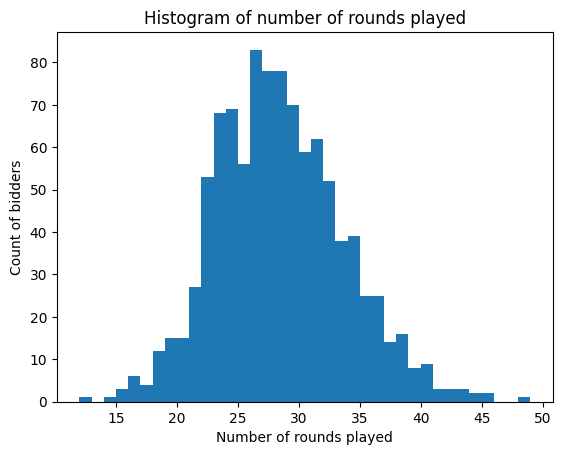

In [9]:
# look at the full distribution of num_auctions_played

min_ = df_bidders[["num_auctions_played"]].describe().loc["min", "num_auctions_played"]
max_ = df_bidders[["num_auctions_played"]].describe().loc["max", "num_auctions_played"]

plt.hist(df_bidders.num_auctions_played, bins=int(max_-min_))
plt.xlabel("Number of rounds played")
plt.ylabel("Count of bidders")
plt.title("Histogram of number of rounds played");

**I include the above histogram to confirm that each bidder participated in sufficiently many auctions that their results can be taken seriously**

--- 
## 4: Visualize Results <a id='visualize'></a> 
[jump to top](#top)<br>

### Univariate analysis

We will begin by examining the distribution of the variable of interest: `average_final_balance`.

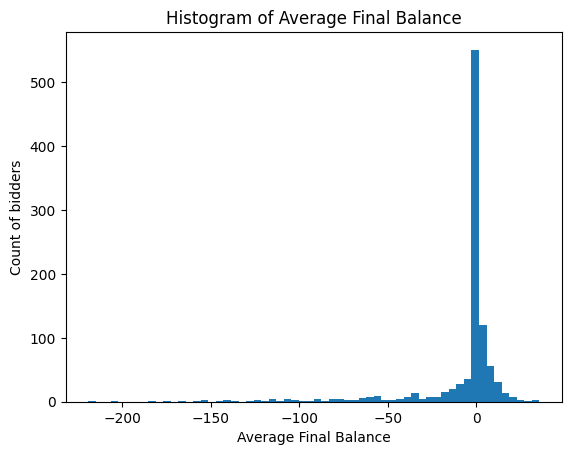

In [10]:
plt.hist(df_bidders.average_final_balance, bins=60)
plt.xlabel("Average Final Balance")
plt.ylabel("Count of bidders")
plt.title("Histogram of Average Final Balance");

The above histogram indicates an interestingly shaped distribution. The majority of bidders finished with average final balances of close to zero dollars, both above and below. The positive side of the distribution appears fairly normally distributed. However, the negative side does not exhibit the same behavior, behaving closer to (but not quite) a uniform distribution. Many bidders finished with exactly a zero dollar average final balance.

In [11]:
print("Number of bidders that finished with $0: ", len(df_bidders.loc[df_bidders.average_final_balance==0]))

Number of bidders that finished with $0:  274


In [12]:
print("Number of bidders that finished with between -$2 and $2: ", len(df_bidders.loc[(df_bidders.average_final_balance>-2) & (df_bidders.average_final_balance<2)]))

Number of bidders that finished with between -$2 and $2:  554


### Multivariate analysis

**Visualization idea: scatter plot of all the bidders with alpha on one axis, aggressiveness on the other, and they are colored by their average_final_balance**

This idea won't work as I'm picturing it because the bidders' attributes were created at regular intervals rather than in a stochastic manner. This means that if you scatter alpha on aggressiveness, you will end up with a grid of points and each position will actually have 5 overlapping datapoints (representing the 5 levels of under_cut). 

In [13]:
# address the overlapping problem by averaging over the third attribute

test_df = pd.DataFrame(df_bidders.groupby(["alpha", "aggressiveness"])["average_final_balance"].mean())
test_df = test_df.reset_index()
test_df.sort_values(by="average_final_balance", ascending=False)

,alpha,aggressiveness,average_final_balance
36,0.1,0.80,13.842400
54,0.2,0.70,13.413525
35,0.1,0.75,12.362819
51,0.2,0.55,11.717706
55,0.2,0.75,11.370479
...,...,...,...
139,0.6,0.95,-111.419004
198,0.9,0.90,-118.223890
159,0.7,0.95,-134.581025
179,0.8,0.95,-145.228039


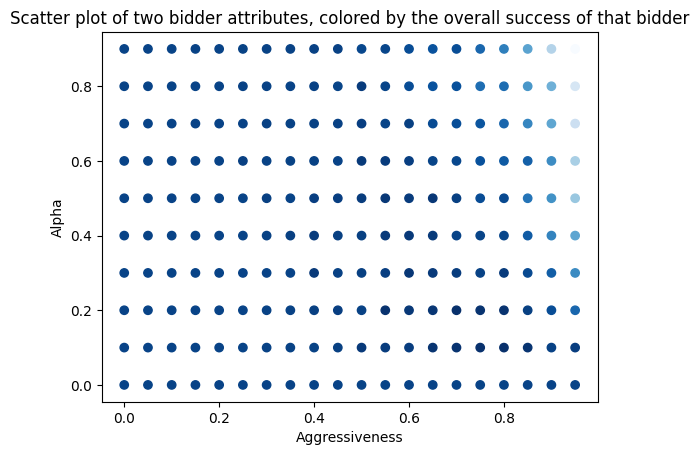

In [14]:
# confirm that the grid of points is created, even though the overlapping problem has been addressed

plt.scatter(test_df.aggressiveness, test_df.alpha, 
            c=test_df.average_final_balance, 
            cmap="Blues")
plt.xlabel("Aggressiveness")
plt.ylabel("Alpha")
plt.title("Scatter plot of two bidder attributes, colored by the overall success of that bidder");

In [15]:
# create a pivot table which will be used to make a heatmap below

piv_tab = pd.pivot_table(test_df, index="aggressiveness", columns="alpha", fill_value="average_final_balance")
piv_tab

average_final_balance                                   \
alpha                            0.0        0.1        0.2        0.3   
aggressiveness                                                          
0.00                             0.0   0.000000   0.000000   0.000000   
0.05                             0.0   0.000000   0.048699  -0.000510   
0.10                             0.0   0.000000   0.000000   0.000000   
0.15                             0.0   0.000000   0.100674   0.005077   
0.20                             0.0   0.000000   0.000000   0.000000   
0.25                             0.0   0.000000   0.075791   0.081082   
0.30                             0.0   0.896047   1.007879   0.361725   
0.35                             0.0   0.468068   0.797368   0.083869   
0.40                             0.0   0.752087   2.132457   6.433625   
0.45                             0.0   2.367823   2.954629   1.878639   
0.50                             0.0   6.560083   1.045410   2.476745   
0.55                             0.0   4.264559  11.717706   3.054805   
0.60                             0.0   3.691079   7.671535   7.927729   
0.65                             0.0  10.382636   9.328974   5.871099   
0.70                             0.0  11.303867  13.413525   4.537781   
0.75                             0.0  12.362819  11.370479   0.573651   
0.80                             0.0  13.842400  10.904427   5.610170   
0.85                             0.0  10.686452   2.341107  -4.629940   
0.90                             0.0   1.080445  -7.184136 -20.213437   
0.95                             0.0   4.021094 -26.026706 -52.977597   

                                                                           \
alpha                 0.4         0.5         0.6         0.7         0.8   
aggressiveness                                                              
0.00             0.000000    0.000000    0.000000    0.000000    0.000000   
0.05             0.620039    0.002893   -0.001700    0.020858    0.009275   
0.10            -0.005598    0.001905    0.011338    0.021607    0.042375   
0.15             0.120523    0.022093    0.044691    0.167989    0.096372   
0.20            -0.002222    0.204365    0.048411    0.133792    0.431839   
0.25             0.424884    0.294289    1.960405    0.586338    1.685214   
0.30             1.497570    2.404103    1.132277    1.276354    0.616056   
0.35             2.391480    0.187895    0.561605    0.626230    0.115748   
0.40             4.460688    2.824530    1.514932    1.767920    1.491564   
0.45             2.032058    3.053241   -0.049735    1.823443   -0.575894   
0.50             2.332274    4.764316    5.959068    2.698747    5.541105   
0.55             5.668651    8.026635    5.341725   -0.317138   -0.298880   
0.60             6.931565    4.936283    2.967552    2.603738   -6.555625   
0.65             6.182499    8.360652   -0.337293   -5.553179  -10.942951   
0.70             0.394309    2.432549   -2.710612   -8.200063   -9.554425   
0.75            -0.775339   -6.267315  -10.364424  -12.921645  -31.154869   
0.80            -2.392120   -4.042031  -17.065577  -26.143302  -30.072422   
0.85           -17.837688  -36.140896  -21.190580  -48.946995  -61.792232   
0.90           -46.927882  -58.096000  -53.084902  -74.588722  -83.309059   
0.95           -73.263880 -102.718121 -111.419004 -134.581025 -145.228039   

                            
alpha                  0.9  
aggressiveness              
0.00              0.000000  
0.05              0.006657  
0.10              0.175353  
0.15              0.615070  
0.20              0.342244  
0.25              0.496899  
0.30              0.510748  
0.35              0.708976  
0.40              1.463499  
0.45              1.727341  
0.50             -2.525406  
0.55             -1.484924  
0.60             -6.527627  
0.65            -11.261316  
0.70             -7.683008  
0.75            -25.888523  
0.80        

<Axes: xlabel='None-alpha', ylabel='aggressiveness'>

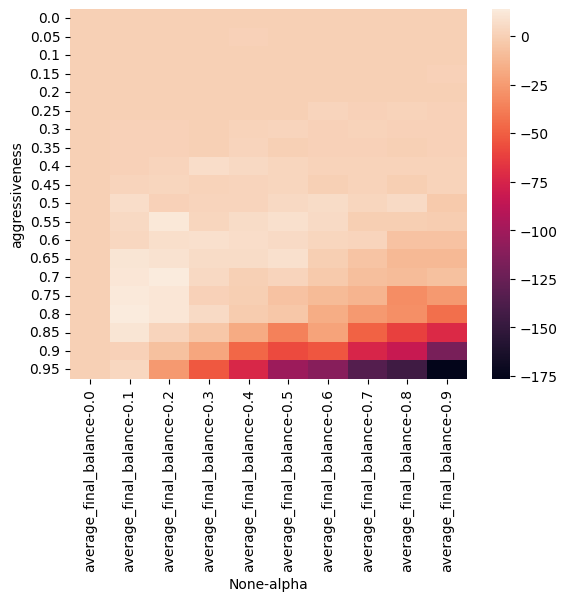

In [16]:
# create the heatmap

sns.heatmap(piv_tab)

**These results are insightful, we can see a small pocket of success in the mid to lower left and a large corner of failure in the bottom right of the heatmap.**